# RESNET50

In [28]:
import os
# Root of data. Change this to match your directory structure. 
# datadir should contain train/ val/ and test/

data_dir = "images"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [29]:
!pip install torch
!pip  install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm import tqdm
# import optimizer library
from torch.optim.lr_scheduler import StepLR

import os
import copy

# display image
!pip install -U image
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version:  1.8.1+cpu
Torchvision Version:  0.9.1+cpu


In [30]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224
    
    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, num_classes)
        )
        input_size = 224  
        
    elif model_name == "resnet101":
        """ Resnet101
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224    

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size



In [31]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    
    # add random rotation to data augmentation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.RandomRotation(25),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    class_names = image_datasets['train'].classes
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict, class_names


In [32]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()
    
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # scheduler step
#             scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_acc, val_losses, val_acc


In [33]:
def make_optimizer(model):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    # Use SGD
    #optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    optimizer = optim.Adam(params_to_update, lr=0.001)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

In [34]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet50"

# Number of classes in the dataset
# Superficial-Intermediate, Parabasal, Koilocytotic, Dysketarotic, Metaplastic
num_classes = 3

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 50

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = True

# data dir
data_dir = "images"

In [35]:
# Initialize the model
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
# get dataloaders
dataloaders, class_name = get_dataloaders(input_size, batch_size, shuffle_datasets)
# loss function
criterion = get_loss()

In [9]:
# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
# scheduler for optimizing
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [10]:
# Train the model!
trained_model, train_losses, train_acc, val_losses, val_acc = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

Epoch 0/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.7316 Acc: 0.7594


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5155 Acc: 0.8646

Epoch 1/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.5580 Acc: 0.8099


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 22.4570 Acc: 0.6245

Epoch 2/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4723 Acc: 0.8354


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4130 Acc: 0.8341

Epoch 3/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4494 Acc: 0.8327


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2814 Acc: 0.8996

Epoch 4/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3817 Acc: 0.8664


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3401 Acc: 0.8952

Epoch 5/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3769 Acc: 0.8680


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2664 Acc: 0.9170

Epoch 6/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3948 Acc: 0.8577


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2225 Acc: 0.9214

Epoch 7/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3474 Acc: 0.8783


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1778 Acc: 0.9520

Epoch 8/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3492 Acc: 0.8876


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1555 Acc: 0.9389

Epoch 9/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3485 Acc: 0.8838


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2920 Acc: 0.8646

Epoch 10/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3040 Acc: 0.8919


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1967 Acc: 0.9258

Epoch 11/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3483 Acc: 0.8751


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2063 Acc: 0.9214

Epoch 12/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2826 Acc: 0.9006


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2084 Acc: 0.9258

Epoch 13/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3106 Acc: 0.8892


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1666 Acc: 0.9432

Epoch 14/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2956 Acc: 0.8973


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2011 Acc: 0.9258

Epoch 15/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2857 Acc: 0.8946


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1827 Acc: 0.9432

Epoch 16/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2941 Acc: 0.8973


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2620 Acc: 0.8996

Epoch 17/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2690 Acc: 0.9033


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1595 Acc: 0.9389

Epoch 18/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3028 Acc: 0.8957


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1959 Acc: 0.9214

Epoch 19/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3106 Acc: 0.8876


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.4533 Acc: 0.9127

Epoch 20/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3796 Acc: 0.8756


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1900 Acc: 0.9127

Epoch 21/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3344 Acc: 0.8745


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1861 Acc: 0.9389

Epoch 22/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3417 Acc: 0.8800


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2600 Acc: 0.9127

Epoch 23/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2906 Acc: 0.8984


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1885 Acc: 0.9301

Epoch 24/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3232 Acc: 0.8908


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2809 Acc: 0.9083

Epoch 25/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2916 Acc: 0.8963


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1992 Acc: 0.9476

Epoch 26/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2695 Acc: 0.9028


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1429 Acc: 0.9520

Epoch 27/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2683 Acc: 0.9044


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2406 Acc: 0.9258

Epoch 28/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3091 Acc: 0.9033


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.6786 Acc: 0.9039

Epoch 29/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3286 Acc: 0.8963


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.7853 Acc: 0.7948

Epoch 30/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3165 Acc: 0.8832


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2622 Acc: 0.9127

Epoch 31/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2963 Acc: 0.9001


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.8541 Acc: 0.7991

Epoch 32/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.4620 Acc: 0.8316


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3559 Acc: 0.8777

Epoch 33/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3530 Acc: 0.8713


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2913 Acc: 0.8690

Epoch 34/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3033 Acc: 0.8946


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2491 Acc: 0.9039

Epoch 35/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3010 Acc: 0.9066


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2176 Acc: 0.9127

Epoch 36/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3211 Acc: 0.8876


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2265 Acc: 0.9170

Epoch 37/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2914 Acc: 0.8990


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2305 Acc: 0.9345

Epoch 38/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2725 Acc: 0.9142


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5661 Acc: 0.9039

Epoch 39/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2905 Acc: 0.8870


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2488 Acc: 0.9563

Epoch 40/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2712 Acc: 0.9087


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.5557 Acc: 0.8384

Epoch 41/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2841 Acc: 0.8995


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2093 Acc: 0.9170

Epoch 42/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2498 Acc: 0.9131


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2754 Acc: 0.8952

Epoch 43/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2628 Acc: 0.9153


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1989 Acc: 0.9432

Epoch 44/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2360 Acc: 0.9104


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1396 Acc: 0.9389

Epoch 45/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2569 Acc: 0.9115


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.3366 Acc: 0.8734

Epoch 46/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.3156 Acc: 0.8914


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2627 Acc: 0.9127

Epoch 47/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2923 Acc: 0.9039


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.2481 Acc: 0.9345

Epoch 48/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2460 Acc: 0.9207


  0%|                                                                                          | 0/116 [00:00<?, ?it/s]

val Loss: 0.1797 Acc: 0.9520

Epoch 49/49
----------


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

train Loss: 0.2510 Acc: 0.9163


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.30s/it]


val Loss: 0.2378 Acc: 0.9476

Training complete in 571m 34s
Best val Acc: 0.956332


In [11]:
# save pretrained weights
torch.save(trained_model.state_dict(), "weights/resnet50")

In [12]:
# x label for training 50 to 100 epoch
x = np.arange(0,50,1)

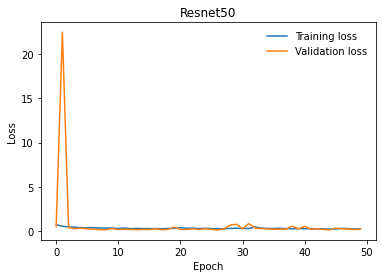

In [13]:
plt.plot(x, train_losses, label='Training loss')
plt.plot(x, val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


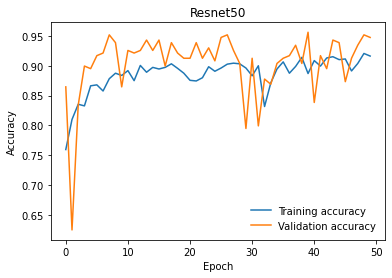

In [14]:
plt.plot(x, train_acc, label='Training accuracy')
plt.plot(x, val_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.title("Resnet50")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


In [36]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 3):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=3, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels


In [37]:
# set data dir to full image
# data_dir = "full_image"
# set data dir to crop image
data_dir = "images"
# get full image data as testing data
dataloaders, class_name = get_dataloaders(input_size, batch_size, True)


In [38]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 3)

# Get predictions for the test set
epoch_loss, top1_acc, top5_acc, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = True, generate_labels = True, k = 3)


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:26<00:00,  1.79s/it]


In [18]:
top1_acc

0.9313304721030042

In [39]:
# data directory of cropped images
data_dir = "images"
class_names = ['normal',
            'abnormal',
            'tumor']

In [40]:
# initialize confusion matrix
confusion_matrix = {x: [0,0,0,0,0] for x in class_name}

In [41]:
# load cropped images 
input_size = 224
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(data_dir,
                         transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.CenterCrop(input_size),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])),
    batch_size = 1,
    shuffle = False)

In [15]:
# move model to GPU
model = model.to(device)
running_top1_correct = 0
# generate confusion matrix on test data
loader = dataloaders['test']
# generate confusion matrix on all cropped data
# loader = train_loader
for inputs, labels in tqdm(loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict output
    outputs = model(inputs)
    _, preds = torch.topk(outputs, k=1, dim=1)
    # generate confusion matrix
    for i in range(len(labels)):
        original_label = int(labels[i])
        confusion_matrix[class_names[original_label]][int(preds[i])] += 1
        
    running_top1_correct += torch.sum(preds[:, 0] == labels.data)

epoch_top1_acc = float(running_top1_correct.double() / len(loader.dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.67s/it]


In [16]:
print(confusion_matrix)
# total accuracy
print(epoch_top1_acc)

{'abnormal': [76, 0, 0, 0, 0], 'normal': [97, 0, 0, 0, 0], 'tumor': [60, 0, 0, 0, 0]}
0.41630901287553645


In [24]:
percentage = {x: [y /sum(confusion_matrix[x]) for y in confusion_matrix[x]] for x in confusion_matrix.keys()}
percentage

{'abnormal': [0.05263157894736842,
  0.868421052631579,
  0.07894736842105263,
  0.0,
  0.0],
 'normal': [0.9587628865979382, 0.0, 0.041237113402061855, 0.0, 0.0],
 'tumor': [0.03333333333333333,
  0.03333333333333333,
  0.9333333333333333,
  0.0,
  0.0]}

In [42]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

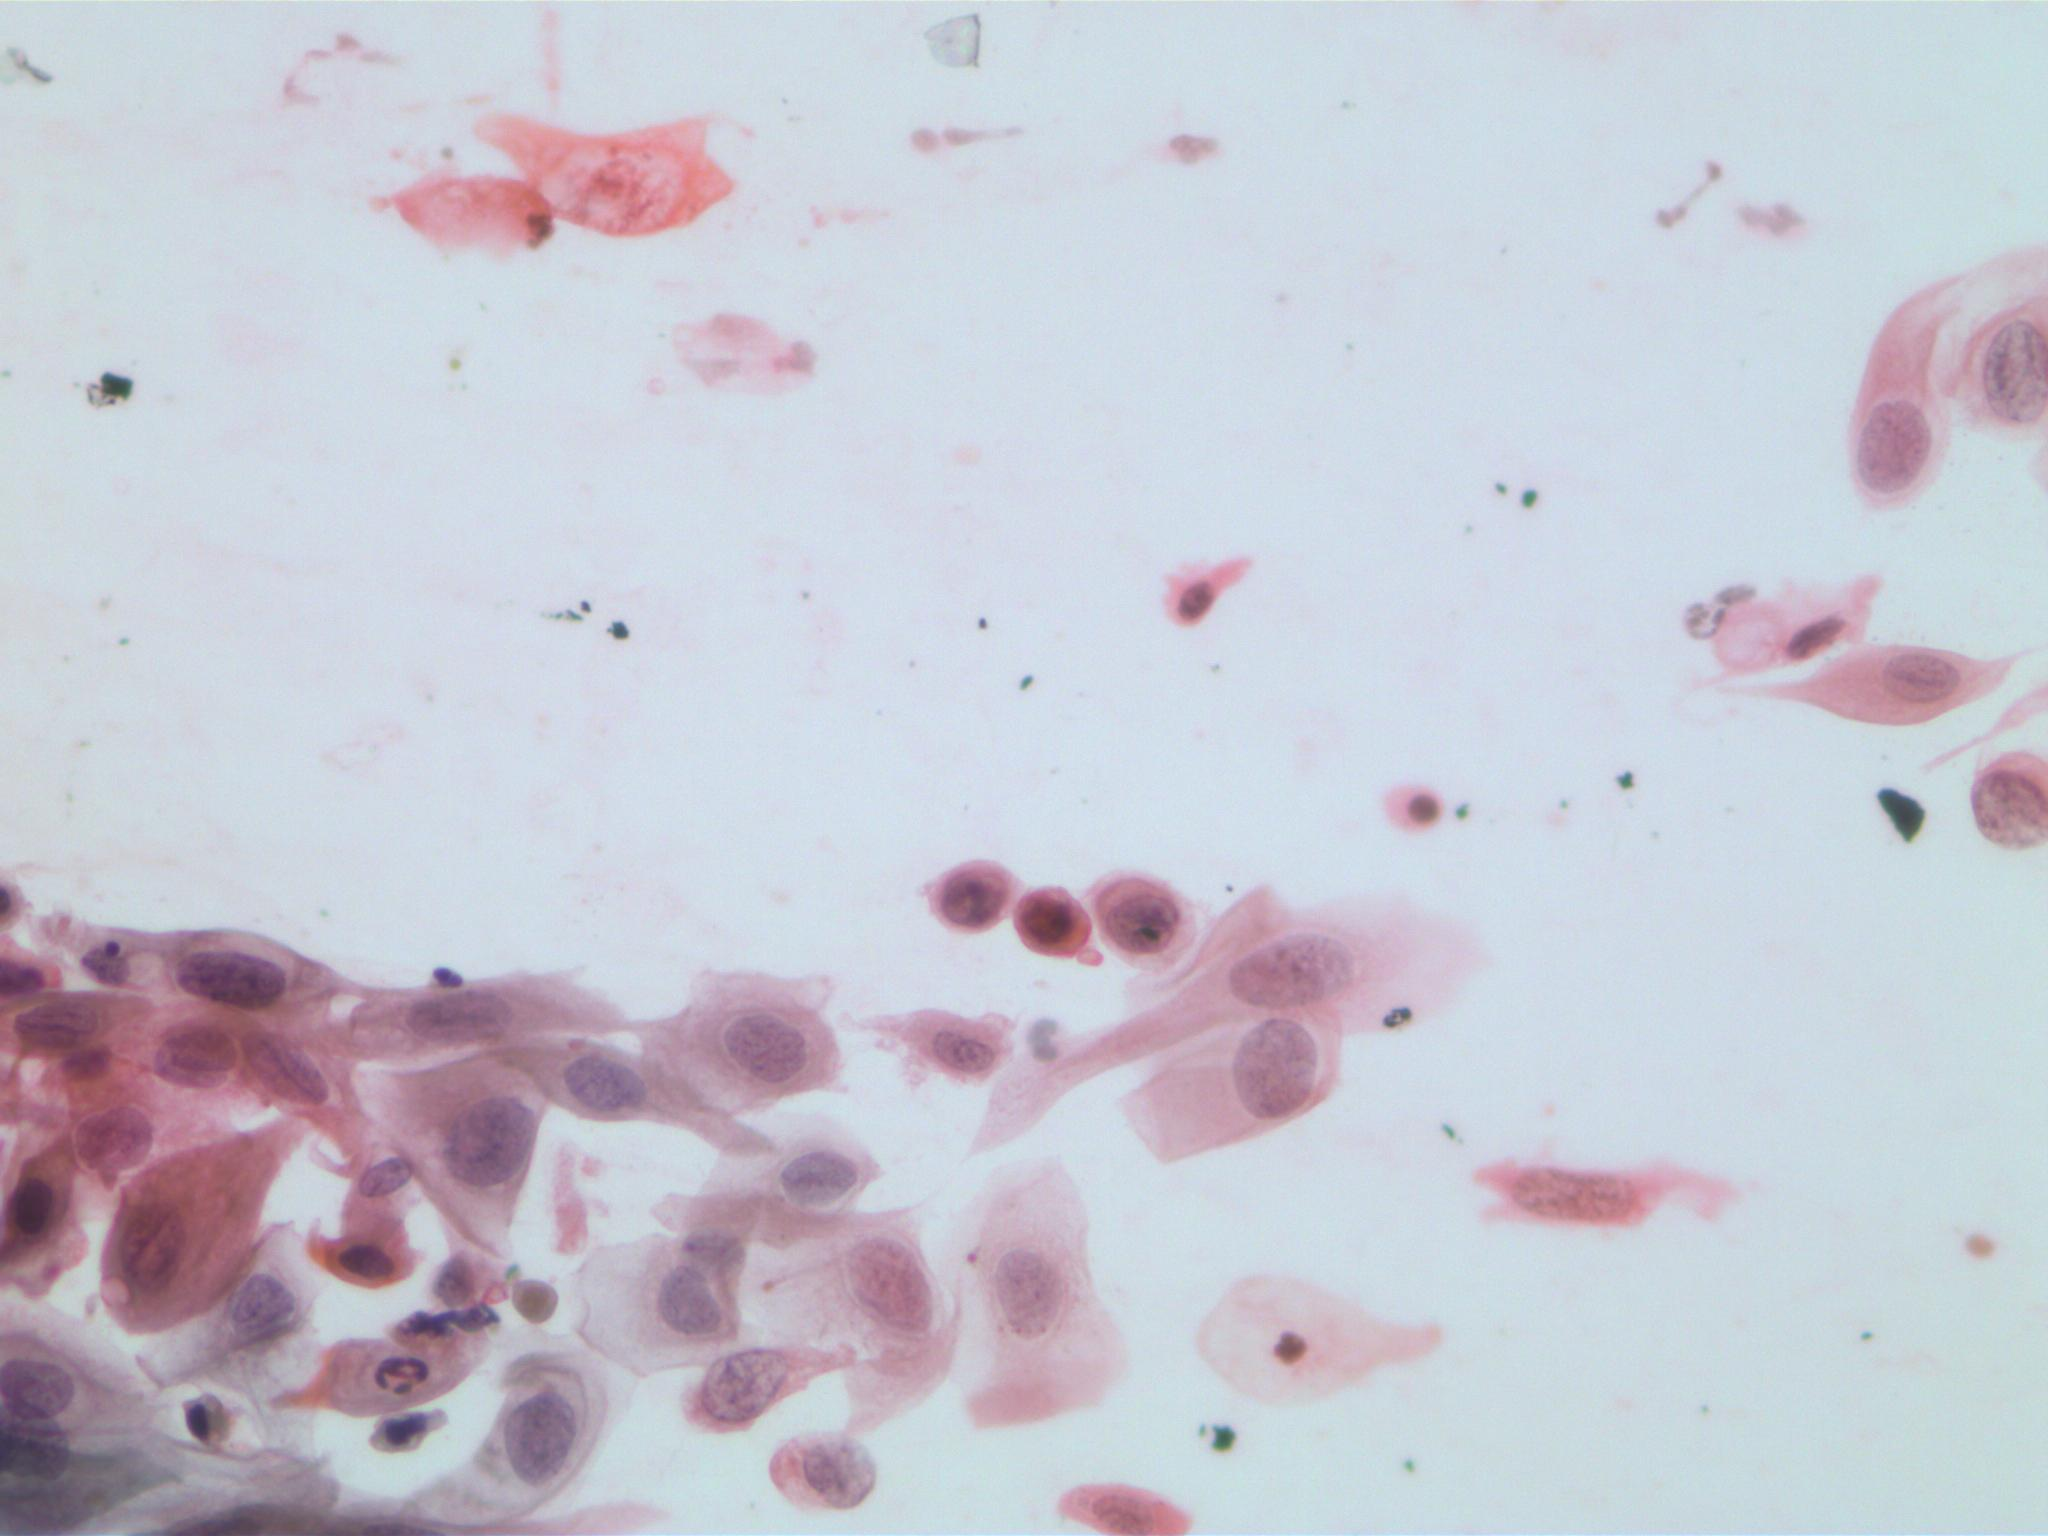

In [43]:
img0 = PIL.Image.open('original_images/abnormal/575.bmp').convert('RGB')
img_numpy = np.array(img0)
showarray(img_numpy)

In [44]:
img_numpy.shape

(1536, 2048, 3)

torch.Size([3, 252, 252])


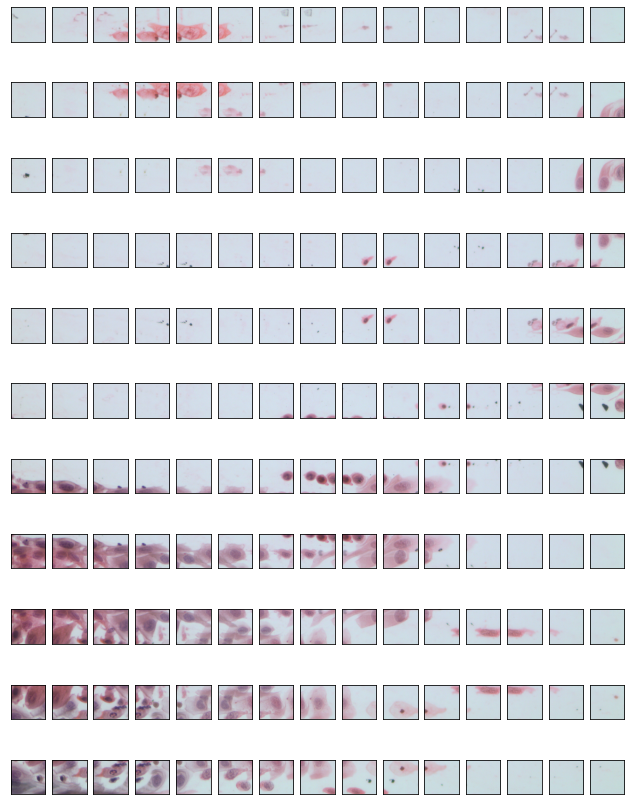

In [45]:
# patches = x.unfold(dim, size, stride).unfold(dim, size, stride).unfold(dim, size, stride)
transt = transforms.ToTensor()
transp = transforms.ToPILImage()
img_t = transt(PIL.Image.open('original_images/abnormal/575.bmp'))

#torch.Tensor.unfold(dimension, size, step)
#slices the images into 8*8 size patches
size = 252
stride = 128
# first color channel dimension, include all three
# width and height dimension find the common factor of the two for size and stride
patches = img_t.data.unfold(0, 3, 3).unfold(1, size, stride).unfold(2, size, stride)
print(patches[0][0][0].shape)

def visualize(patches):
    """Imshow for Tensor."""   
    # number of slices on height
    slice_h = patches.shape[1]
    slice_w = patches.shape[2]
    fig = plt.figure(figsize=(slice_h, slice_w))
    for i in range(patches.shape[1]):
        for j in range(patches.shape[2]):
            inp = transp(patches[0][i][j])
            inp = np.array(inp)
            ax = fig.add_subplot(slice_h, slice_w, ((i*slice_w)+j)+1, xticks=[], yticks=[])
            plt.imshow(inp)

visualize(patches)


normal: 0.9985809326171875


<ipython-input-46-f831a2a9d8d5>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = sm(prob)


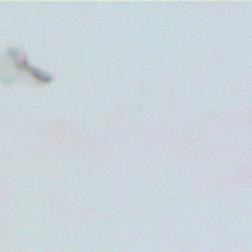

normal: 0.9985847473144531


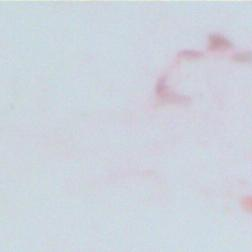

normal: 0.998121440410614


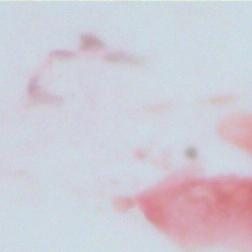

normal: 0.9955474138259888


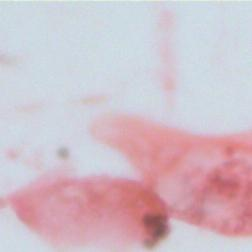

normal: 0.997083842754364


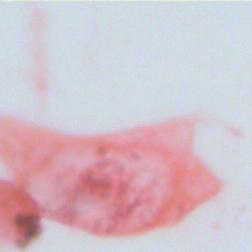

normal: 0.9980144500732422


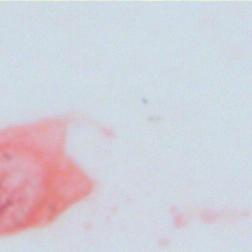

normal: 0.9989835619926453


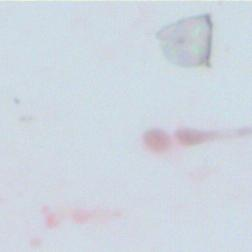

normal: 0.9989709854125977


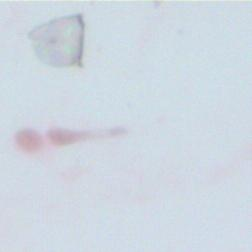

normal: 0.998880922794342


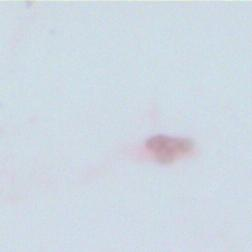

normal: 0.9986774325370789


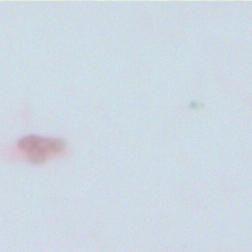

normal: 0.998883068561554


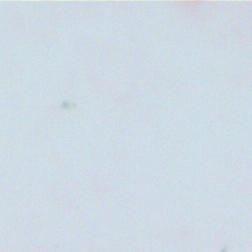

normal: 0.9989808201789856


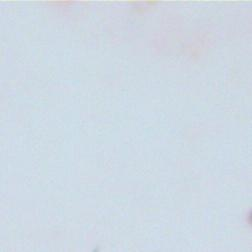

normal: 0.9986903071403503


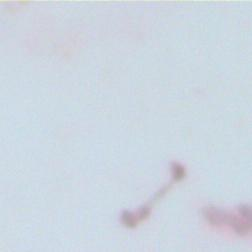

normal: 0.9987672567367554


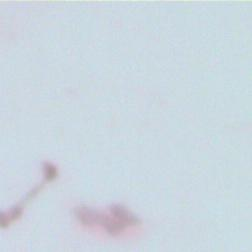

normal: 0.9988943934440613


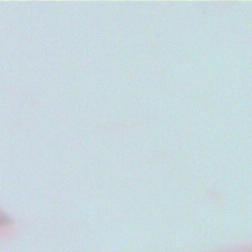

normal: 0.998741090297699


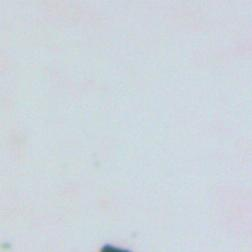

normal: 0.9988671541213989


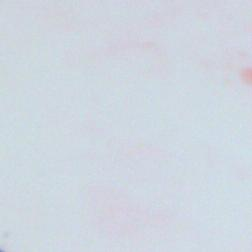

normal: 0.998943030834198


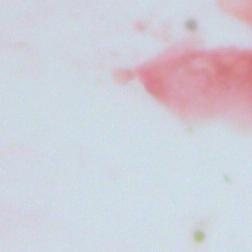

normal: 0.9987372756004333


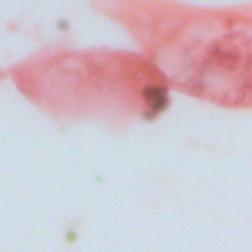

normal: 0.9989860653877258


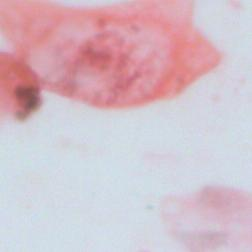

normal: 0.9988495111465454


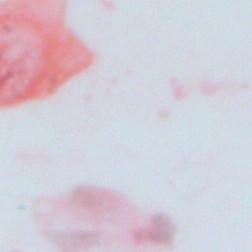

normal: 0.9990243911743164


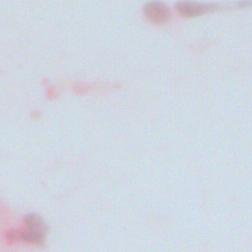

normal: 0.9991762042045593


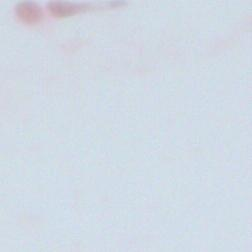

normal: 0.9992033839225769


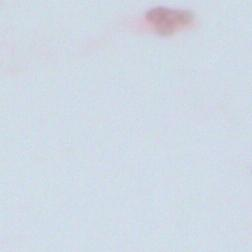

normal: 0.9990407824516296


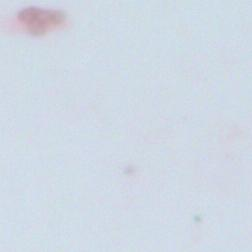

normal: 0.9988961219787598


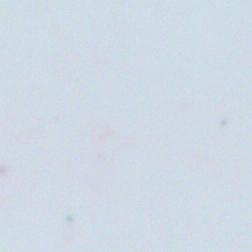

normal: 0.9988868832588196


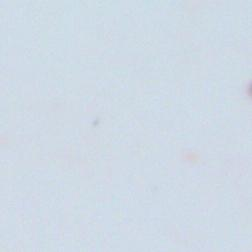

normal: 0.998986542224884


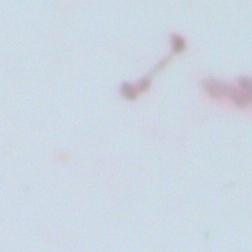

normal: 0.9987666606903076


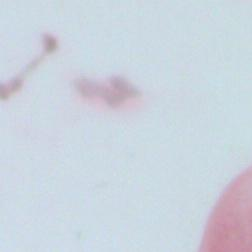

normal: 0.9957119226455688


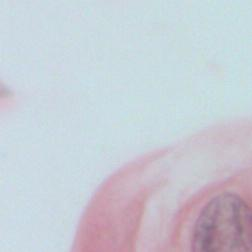

normal: 0.9990291595458984


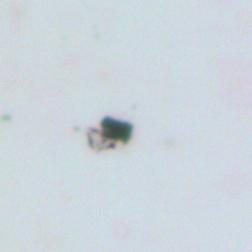

normal: 0.998809814453125


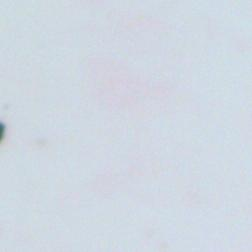

normal: 0.9990020394325256


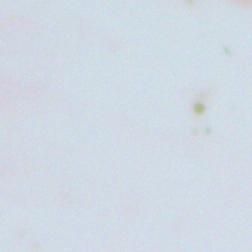

normal: 0.9989680051803589


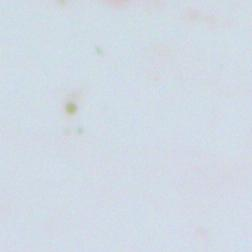

normal: 0.9990824460983276


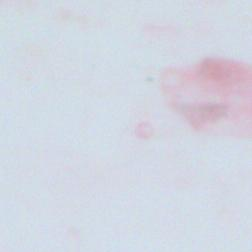

normal: 0.9990850687026978


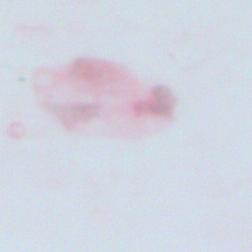

normal: 0.99897301197052


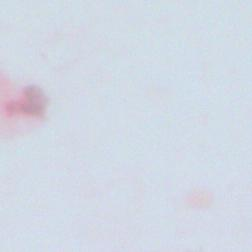

normal: 0.9990429282188416


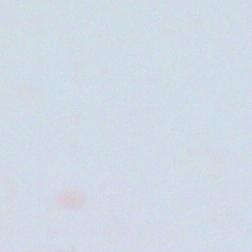

normal: 0.9990550875663757


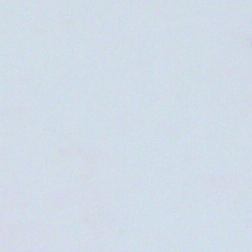

normal: 0.9990768432617188


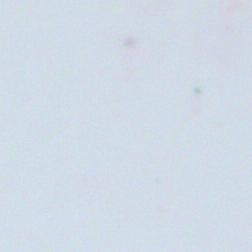

normal: 0.9990350008010864


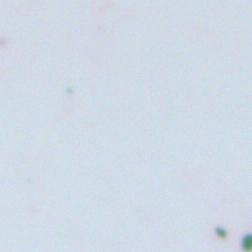

normal: 0.9988227486610413


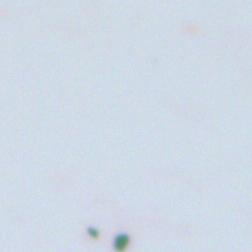

normal: 0.9989662170410156


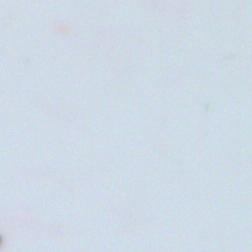

normal: 0.9979179501533508


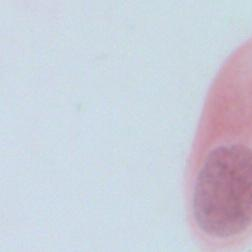

normal: 0.9962762594223022


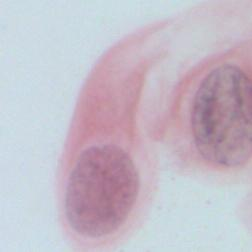

normal: 0.9986855387687683


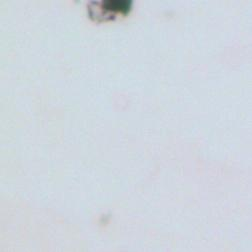

normal: 0.9989032745361328


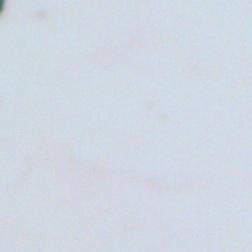

normal: 0.9988722205162048


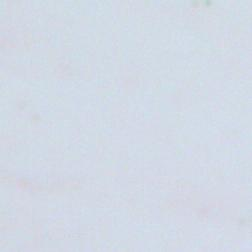

normal: 0.9988883137702942


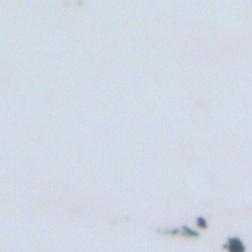

normal: 0.9989778995513916


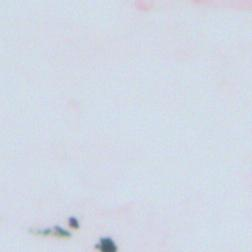

normal: 0.9991059899330139


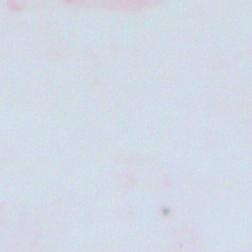

normal: 0.9989475607872009


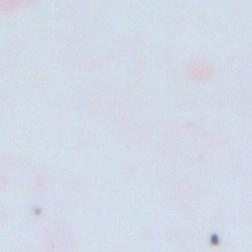

normal: 0.998819887638092


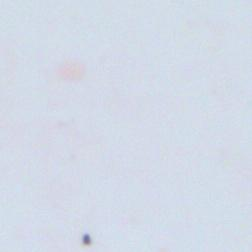

normal: 0.9986525177955627


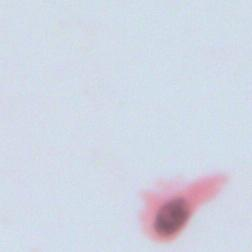

normal: 0.9989513158798218


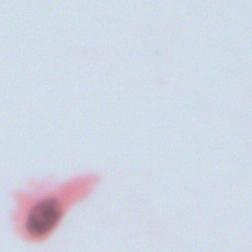

normal: 0.9990530610084534


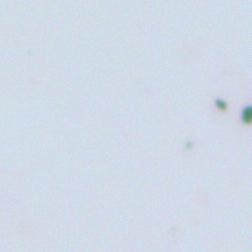

normal: 0.9989744424819946


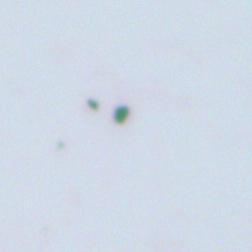

normal: 0.9983308911323547


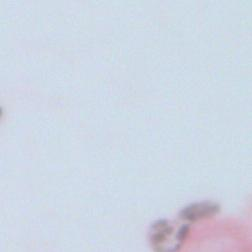

normal: 0.9963841438293457


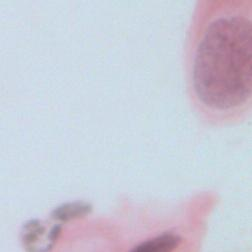

normal: 0.9989319443702698


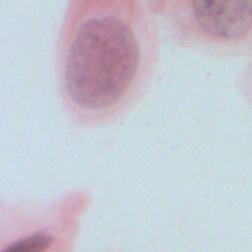

normal: 0.9985643029212952


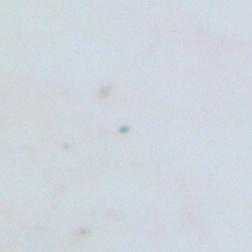

normal: 0.9987530708312988


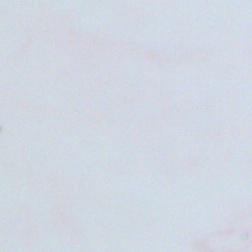

normal: 0.9987603425979614


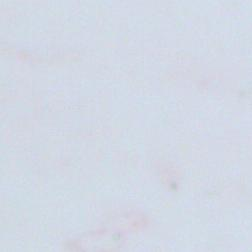

normal: 0.9989001750946045


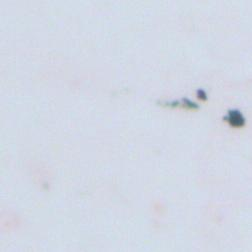

normal: 0.9988672733306885


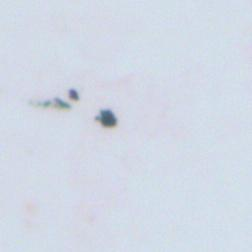

normal: 0.9991057515144348


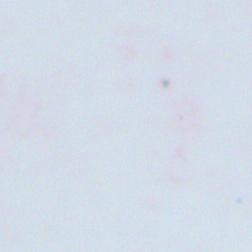

normal: 0.999025821685791


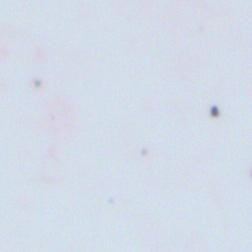

normal: 0.9990531802177429


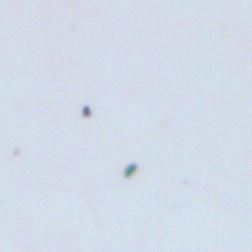

normal: 0.9991934895515442


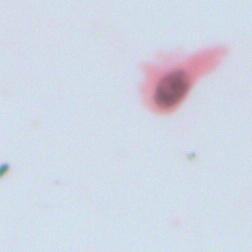

normal: 0.9990416169166565


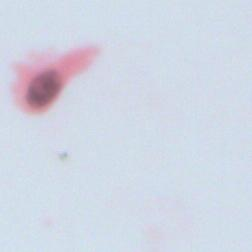

normal: 0.9989619255065918


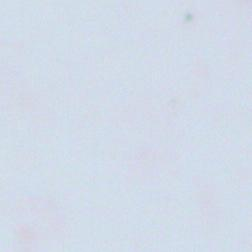

normal: 0.9989022016525269


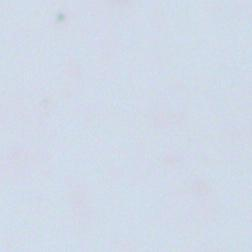

normal: 0.9986547231674194


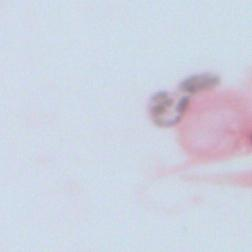

normal: 0.9979718327522278


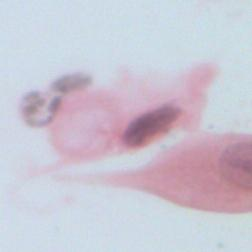

normal: 0.9957951307296753


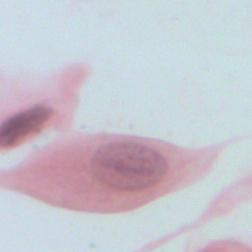

normal: 0.9984001517295837


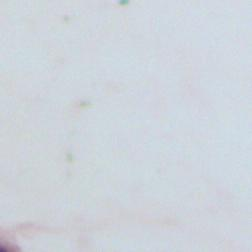

normal: 0.9985456466674805


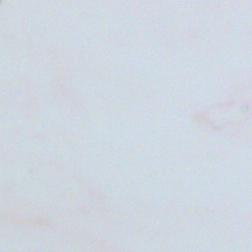

normal: 0.9988862872123718


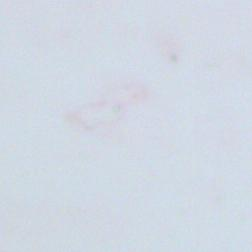

normal: 0.9988332390785217


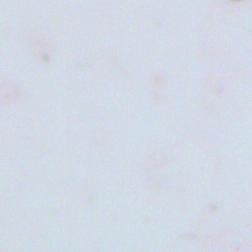

normal: 0.9990046620368958


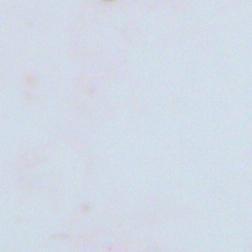

normal: 0.9990668892860413


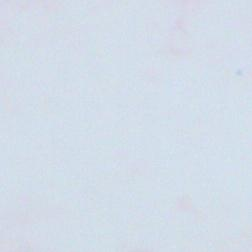

normal: 0.9986513257026672


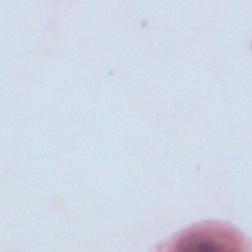

normal: 0.9984446167945862


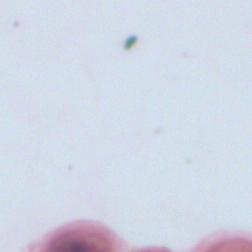

normal: 0.9989134073257446


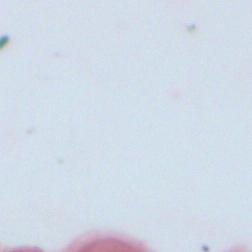

normal: 0.9991125464439392


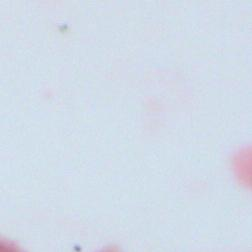

normal: 0.9991888403892517


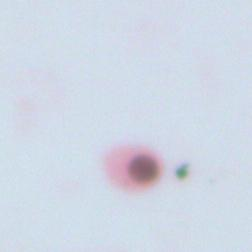

normal: 0.9986018538475037


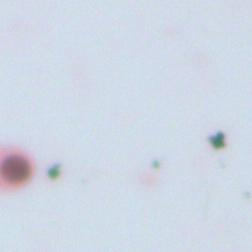

normal: 0.9987896084785461


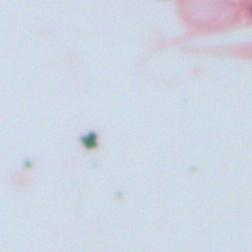

normal: 0.9986121654510498


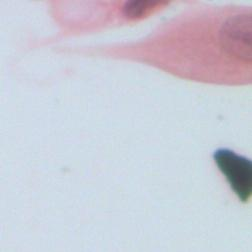

normal: 0.9987825751304626


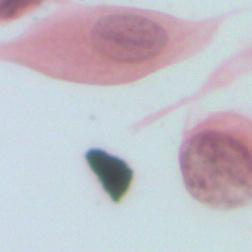

normal: 0.9446204304695129


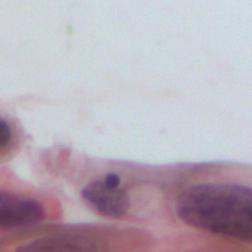

normal: 0.9744680523872375


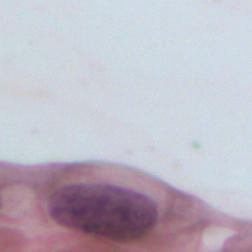

normal: 0.9944671392440796


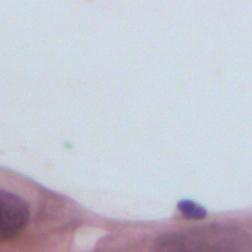

normal: 0.997365415096283


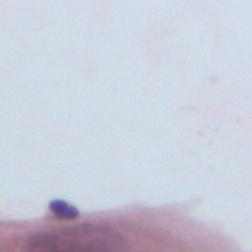

normal: 0.9977066516876221


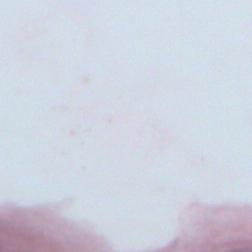

normal: 0.9983015060424805


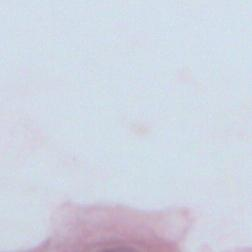

normal: 0.9972152709960938


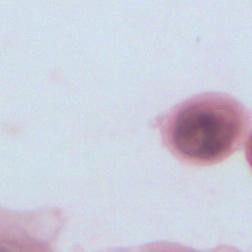

normal: 0.9890100359916687


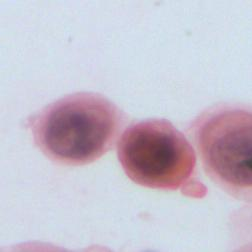

normal: 0.9738190770149231


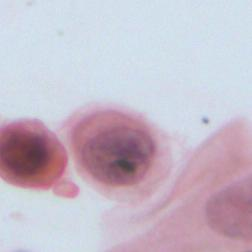

normal: 0.9873557686805725


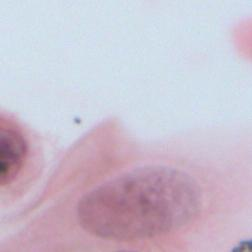

normal: 0.9984791874885559


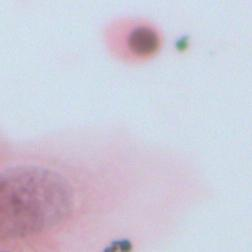

normal: 0.999042809009552


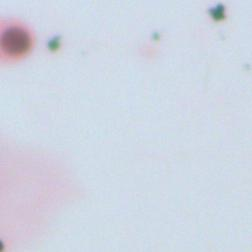

normal: 0.9989626407623291


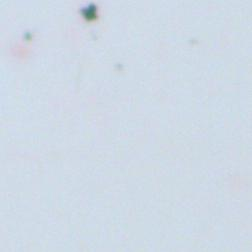

normal: 0.9986386895179749


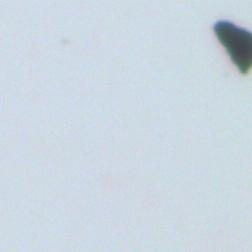

normal: 0.9985672235488892


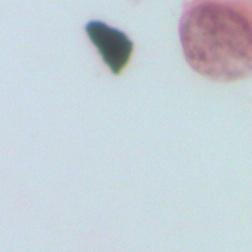

normal: 0.5649223327636719


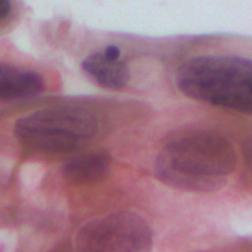

normal: 0.5241146087646484


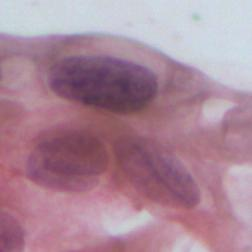

normal: 0.6228232979774475


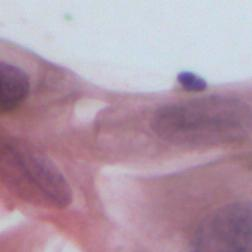

normal: 0.7550442218780518


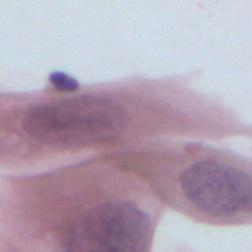

normal: 0.8953827023506165


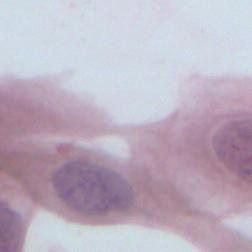

normal: 0.9859519004821777


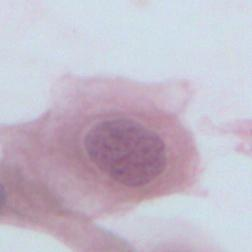

normal: 0.9902529716491699


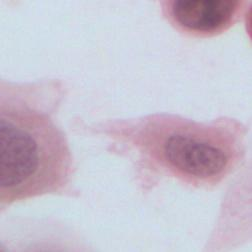

normal: 0.9963297247886658


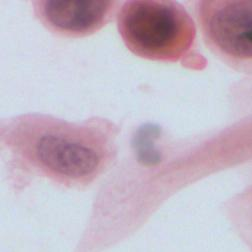

normal: 0.9880329370498657


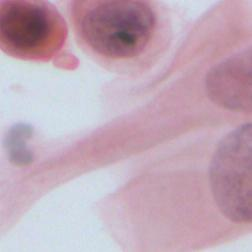

normal: 0.990948498249054


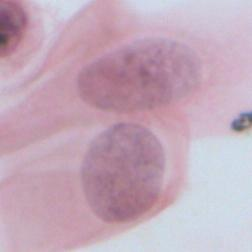

normal: 0.9972975850105286


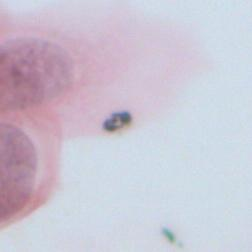

normal: 0.9988106489181519


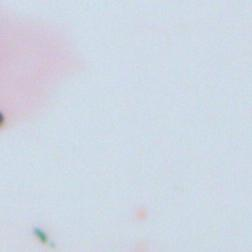

normal: 0.9987757802009583


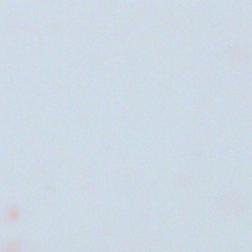

normal: 0.9988253712654114


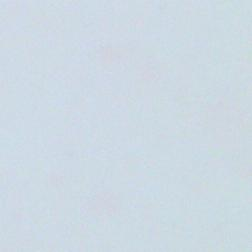

normal: 0.998790442943573


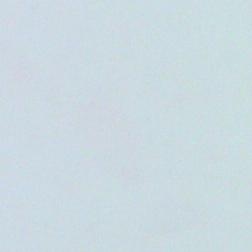

normal: 0.8445075154304504


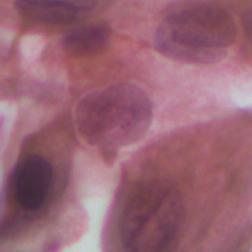

normal: 0.8198146820068359


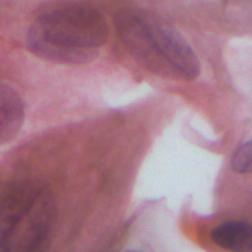

normal: 0.9585781097412109


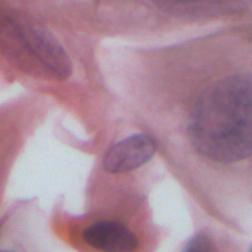

normal: 0.9454265236854553


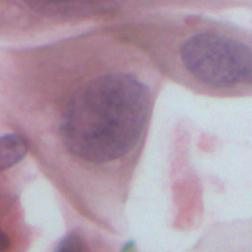

normal: 0.9685045480728149


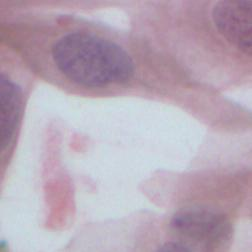

normal: 0.9860952496528625


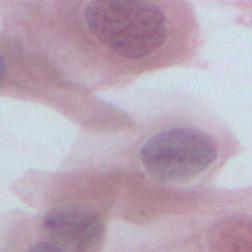

normal: 0.9865368008613586


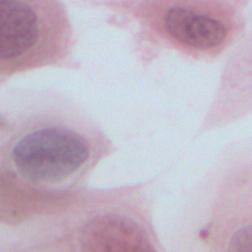

normal: 0.998764157295227


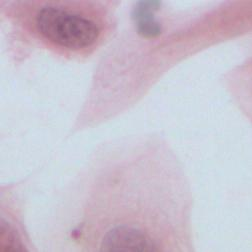

normal: 0.9989194869995117


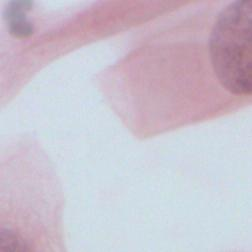

normal: 0.9982272982597351


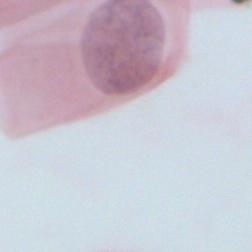

normal: 0.9987382292747498


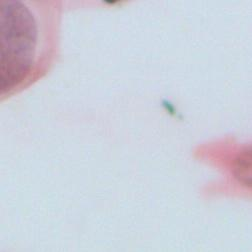

normal: 0.996967613697052


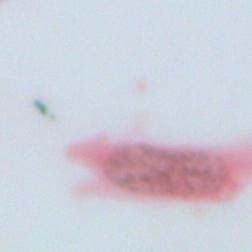

normal: 0.9954196214675903


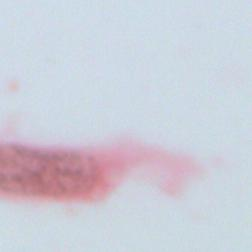

normal: 0.998445451259613


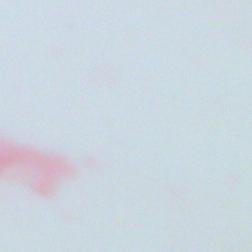

normal: 0.9985790252685547


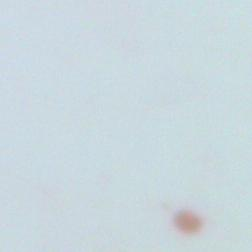

normal: 0.8795576691627502


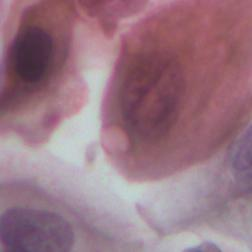

normal: 0.75075763463974


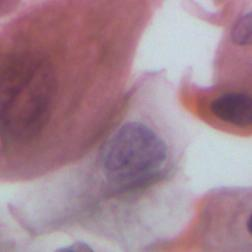

normal: 0.9548746347427368


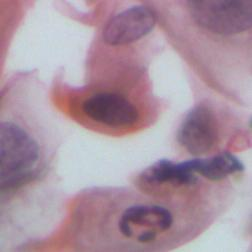

normal: 0.9856622815132141


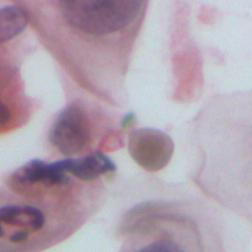

normal: 0.9826595783233643


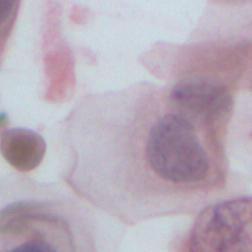

normal: 0.9775062799453735


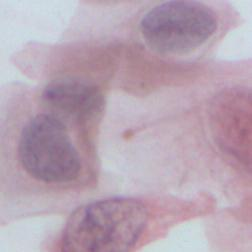

normal: 0.9966025352478027


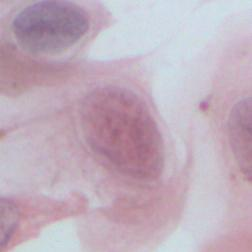

normal: 0.9959057569503784


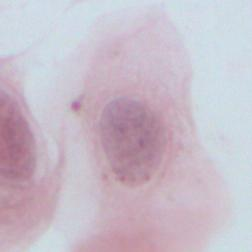

normal: 0.995244562625885


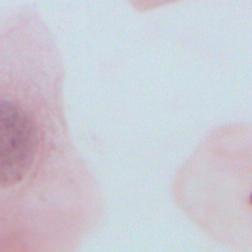

normal: 0.9978979825973511


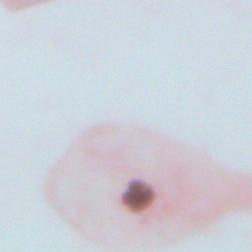

normal: 0.9979451298713684


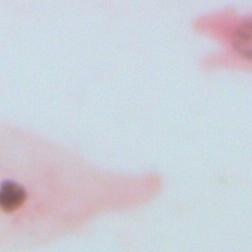

normal: 0.9990330934524536


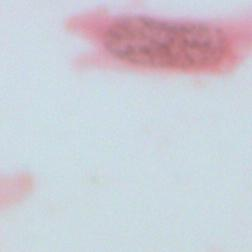

normal: 0.9992160797119141


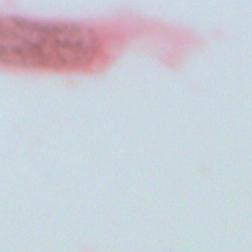

normal: 0.9986530542373657


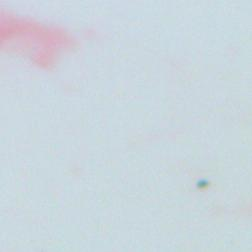

normal: 0.998552143573761


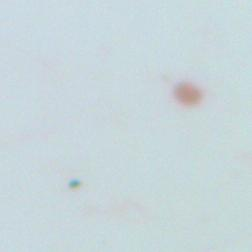

normal: 0.7197287678718567


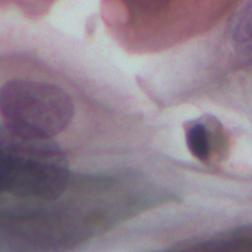

normal: 0.9300698637962341


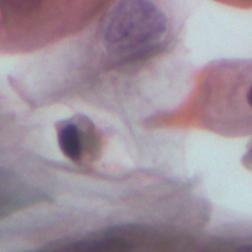

normal: 0.9152485132217407


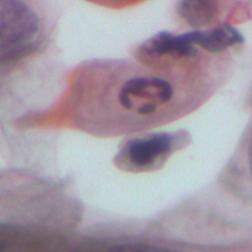

normal: 0.9692596793174744


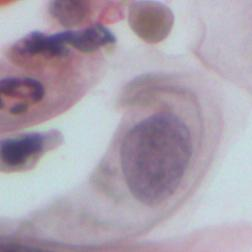

normal: 0.9889212846755981


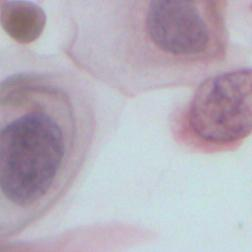

normal: 0.9961923360824585


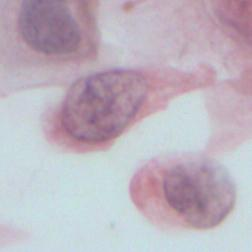

normal: 0.9978845715522766


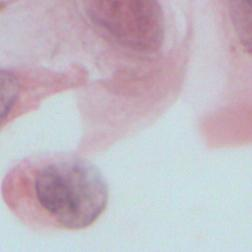

normal: 0.9985742568969727


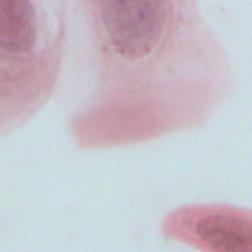

normal: 0.9982250332832336


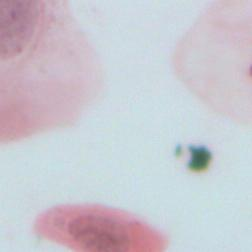

normal: 0.9993535876274109


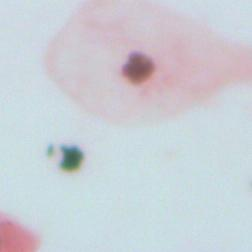

normal: 0.9988241791725159


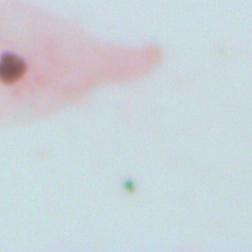

normal: 0.998781144618988


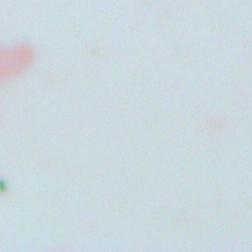

normal: 0.9985461235046387


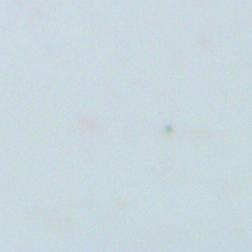

normal: 0.9987841248512268


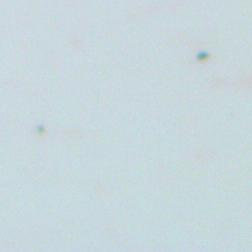

normal: 0.9985861778259277


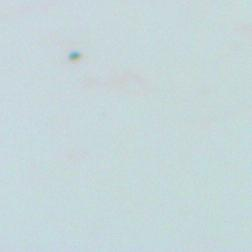

In [46]:

input_size = 224
for i in range(patches.shape[1]):
    for j in range(patches.shape[2]):
        normalize = transforms.Compose([
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        # print image 
        
        # resize tensor to model input size
        x = F.interpolate(patches[0][i][j], size=224) 
        im = normalize(x)
        out = model(im.unsqueeze(0)).squeeze()
        # get the probability and category of top5 prediction
        prob, categories = out.topk(3)
        # convert the probability to softmax
        sm = torch.nn.Softmax()
        probabilities = sm(prob) 
        
        print(class_name[int(categories[0])] + ": " + str(float(probabilities[0])))
        inp = transp(patches[0][i][j])
        inp = np.array(inp)
        showarray(inp)